In [44]:
from datasets import load_dataset
from helical.utils import get_anndata_from_hf_dataset
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt


## 1. Load test datasets to apply perturbations

In [45]:
yolksac_hf_dataset = load_dataset("helical-ai/yolksac_human", trust_remote_code=True, download_mode="reuse_cache_if_exists") #load hf_dataset from helical's profile in hf
yolksac_anndata = get_anndata_from_hf_dataset(yolksac_hf_dataset["train"])[:100] #generate annData object from huggingface dataset
yolksac_anndata

Generating train split:   0%|          | 0/25344 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6336 [00:00<?, ? examples/s]

/Users/mo2016/Library/Caches/pypoetry/virtualenvs/scc-helical--RZZoshj-py3.11/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


View of AnnData object with n_obs × n_vars = 100 × 37318
    obs: 'LVL1', 'LVL2', 'LVL3'
    var: 'gene_name'

## 2. Add biologically relevant noise 

In [46]:
def add_noise(anndata, noise_distribution='logNormal', scaling_factor=1):
    # Compute mean for each gene
    gene_means = np.array(anndata.X.mean(axis=0)).flatten()
    gene_means = np.where(gene_means == 0, 1e-6, gene_means)  # change zeros by 1e-6 to avoid division errors

    # Compute std for each gene
    gene_stds = np.sqrt((anndata.X.power(2).mean(axis=0) - np.power(gene_means, 2))).flatten()  # Sparse std computation

    # Add noise gaussian noise
    if noise_distribution == 'normal':
        noise = np.abs(np.random.normal(loc=1, scale=scaling_factor * gene_stds,
                                        size=anndata.X.shape))  # abs used to avoid negative values

    # Add logNormal noise (avoids negative numbers)
    elif noise_distribution == 'logNormal':
        gene_cv = gene_stds / gene_means  # Coefficient of variation used in logNormal
        noise = np.random.lognormal(mean=0, sigma=scaling_factor * gene_cv, size=anndata.X.shape)

    # both distributions have a scaling factor to introduce more or less noise.

    # Apply noise to the sparse matrix
    anndata.X = anndata.X.multiply(noise)  # Element-wise multiplication for sparse matrices
    anndata.X = csr_matrix(np.round(anndata.X).astype(int))  # Ensure the result is a sparse integer matrix
    assert not np.any(anndata.X.toarray() < 0)  # test to check no negative numbers generated

    return anndata


In [47]:
yolksac_anndata_noise = add_noise(yolksac_anndata, noise_distribution='logNormal', scaling_factor=1)

/var/folders/bt/1cqt3cks1sl9cz4dfwlyxhpm0000gn/T/ipykernel_4528/581709919.py:7: RuntimeWarning: invalid value encountered in sqrt
  gene_stds = np.sqrt((anndata.X.power(2).mean(axis=0) - np.power(gene_means, 2))).flatten()  # Sparse std computation


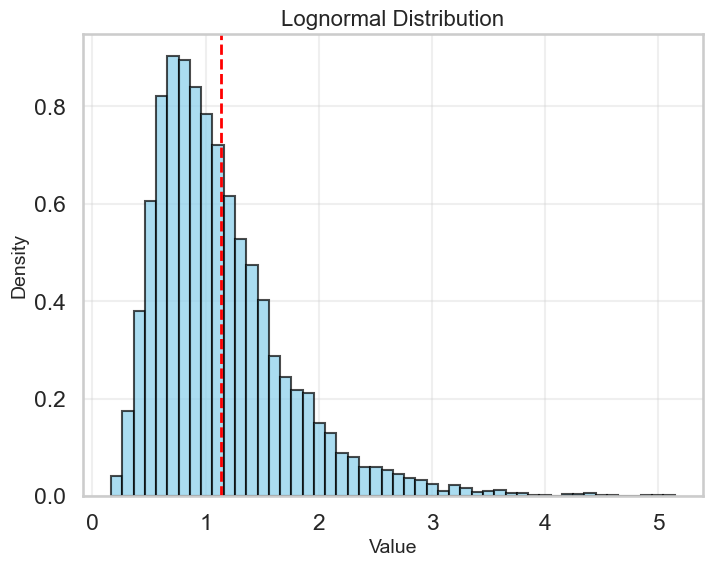

In [48]:
# Generate a lognormal distribution
mu, sigma = 0, 0.5  # Mean and standard deviation of the underlying normal distribution
sample_size = 10000  # Number of samples
scaling_factor=1
# Generate random samples
data = np.random.lognormal(mean=mu, sigma=scaling_factor*sigma, size=sample_size)
mean_value = np.mean(data)

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(data, bins=50, density=True, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.title('Lognormal Distribution', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(alpha=0.3)
plt.show()


## 3. Add perturbations


In [49]:
# This function takes as inputs anndata (dataset which will be subjected to gene perturbations) and the specified perturbation
# Both upregulation, downregulation, deletino and gene saturation can be simulated
# Multiple gene perturbations can be simulated
def add_perturbations(anndata_subset, anndata, gene_perturbations):
    anndata_subset_perturbed = anndata_subset.copy()
    for gene, perturbation in gene_perturbations.items():
        if perturbation == 'down':
            min_value = anndata[:, gene].X.min()
            anndata_subset_perturbed[:, gene].X = int(min_value)

        if perturbation == 'up':
            max_value = anndata[:, gene].X.max()
            anndata_subset_perturbed[:, gene].X = int(max_value)

        if perturbation == 'deletion':
            anndata_subset_perturbed[:, gene].X = 0

        if perturbation == 'saturation':
            anndata_subset_perturbed[:, gene].X = 1000
    return anndata_subset_perturbed




In [50]:
scc_gene_perturbations = {'ITGB1':'up', 'FERMT1':'down', 'CD151':'deletion', 'ARPC2':'saturation'} #Different genes with different types of perturbations
add_perturbations(yolksac_anndata, yolksac_anndata, scc_gene_perturbations)


/Users/mo2016/Library/Caches/pypoetry/virtualenvs/scc-helical--RZZoshj-py3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


AnnData object with n_obs × n_vars = 100 × 37318
    obs: 'LVL1', 'LVL2', 'LVL3'
    var: 'gene_name'

# 4. Add dropouts

In [51]:
#function randomly sets to zero values with low RNA counts
def dropouts(): #function sets to zero values with low counts
    %TODO
    pass